# 12. 트랜스포머로 만드는 대화형 챗봇

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow_datasets as tfds

In [2]:
path_to_dataset = os.getenv('HOME')+'/data/ChatbotData .csv'
path_to_dataset

'/aiffel/data/ChatbotData .csv'

In [3]:
chat_df = pd.read_csv(path_to_dataset)
chat_df.head(10)

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0
5,SD카드 망가졌어,다시 새로 사는 게 마음 편해요.,0
6,SD카드 안돼,다시 새로 사는 게 마음 편해요.,0
7,SNS 맞팔 왜 안하지ㅠㅠ,잘 모르고 있을 수도 있어요.,0
8,SNS 시간낭비인 거 아는데 매일 하는 중,시간을 정하고 해보세요.,0
9,SNS 시간낭비인데 자꾸 보게됨,시간을 정하고 해보세요.,0


결측치 확인

In [4]:
print(chat_df.isnull().sum())

Q        0
A        0
label    0
dtype: int64


In [5]:
question = chat_df['Q']
answer = chat_df['A']

print(type(question), type(answer))

<class 'pandas.core.series.Series'> <class 'pandas.core.series.Series'>


## 데이터 전처리

In [6]:
def preprocess_sentence(sentence):
    sentence = re.sub('[-=+,#/\:^$.@*\"※~&%ㆍ』\\‘|\(\)\[\]\<\>`\'…》]','', sentence) #특수문자제거
    sentence = re.sub(r'[" "]+', " ", sentence) #공백 여러 칸이면 한 칸으로
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r"[^0-9ㄱ-ㅎㅏ-ㅣ가-힣a-zA-Z?.!,]+", " ", sentence)
    sentence = sentence.strip()
    
    return sentence

In [7]:
chat_df['prc_q'] = chat_df['Q'].map(lambda x : preprocess_sentence(x))
chat_df['prc_a'] = chat_df['A'].map(lambda x : preprocess_sentence(x))

In [8]:
chat_df.sample(10)

,Q,A,label,prc_q,prc_a
10986,저를 좋아하는 사람은 없을 거예요.,그건 절대 아닐 거예요.,2,저를 좋아하는 사람은 없을 거예요,그건 절대 아닐 거예요
2705,습관이 안 고쳐져,실패해도 조금씩 고치려고 해보세요.,0,습관이 안 고쳐져,실패해도 조금씩 고치려고 해보세요
9780,반동거중인 여자친구가 나갔으면 좋겠어.,자신의 공간이 필요하다고 말해보세요.,2,반동거중인 여자친구가 나갔으면 좋겠어,자신의 공간이 필요하다고 말해보세요
9935,사랑이 정말 있을까?,없어요. 일시적인 감정 교란일 뿐 아무것도 아니에요.,2,사랑이 정말 있을까 ?,없어요 일시적인 감정 교란일 뿐 아무것도 아니에요
2910,아침 일찍 일어나 조깅하고 있어,건강에 좋은 습관이네요.,0,아침 일찍 일어나 조깅하고 있어,건강에 좋은 습관이네요
3155,여자 어디서 만나,소개팅 시켜달라고 말해보세요.,0,여자 어디서 만나,소개팅 시켜달라고 말해보세요
11301,즉흥적인 여자친구가 고민임.,그게 매력이에요.,2,즉흥적인 여자친구가 고민임,그게 매력이에요
4529,출근 자체가 스트레스야,직장 스트레스가 심한가봐요.,0,출근 자체가 스트레스야,직장 스트레스가 심한가봐요
7443,이별 중독,슬픈 단어네요.,1,이별 중독,슬픈 단어네요
11107,좋아하는 사람에 대한 예의가 없는 것 같아.,예의없는 사람 좋아하지마세요.,2,좋아하는 사람에 대한 예의가 없는 것 같아,예의없는 사람 좋아하지마세요


In [9]:
print('전처리 후의 22번째 질문 샘플: {}'.format(question[21]))
print('전처리 후의 22번째 답변 샘플: {}'.format(answer[21]))

전처리 후의 22번째 질문 샘플: 가스비 장난 아님
전처리 후의 22번째 답변 샘플: 다음 달에는 더 절약해봐요.


In [10]:
chat_df['count_q'] = chat_df['prc_q'].map(lambda x : len(x.split()))
chat_df['count_a'] = chat_df['prc_a'].map(lambda x : len(x.split()))

In [11]:
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(question + answer, 
                                                                      target_vocab_size=2**13)

문장 길이 시각화

question 최소길이 1
question 최대길이 21
question 평균길이 5.4952211790577685
answer 최소길이 1
answer 최대길이 29
answer 평균길이 5.829231159604161


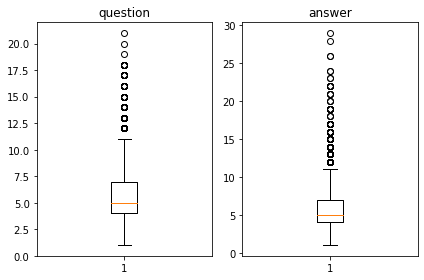

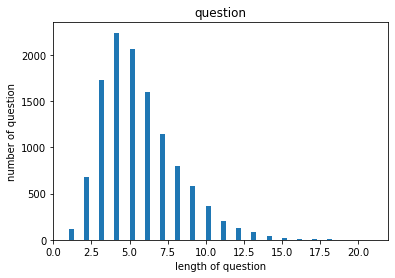

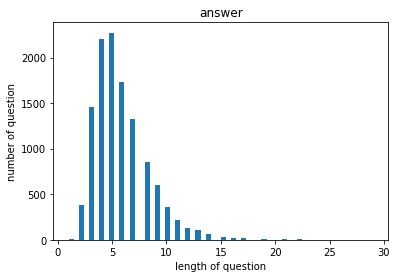

In [12]:
q_len = [len(tokenizer.encode(question[i])) for i in range(len(question))]
a_len = [len(tokenizer.encode(answer[i])) for i in range(len(answer))]

print("question 최소길이", np.min(q_len))
print("question 최대길이", np.max(q_len))
print("question 평균길이", np.mean(q_len))
print("answer 최소길이", np.min(a_len))
print("answer 최대길이", np.max(a_len))
print("answer 평균길이", np.mean(a_len))

plt.subplot(1, 2, 1)
plt.boxplot(q_len)
plt.title('question')
plt.subplot(1, 2, 2)
plt.boxplot(a_len)
plt.title('answer')
plt.tight_layout()
plt.show()

plt.title('question')
plt.hist(q_len, bins = 60)
plt.xlabel('length of question')
plt.ylabel('number of question')
plt.show()

plt.title('answer')
plt.hist(a_len, bins = 60)
plt.xlabel('length of question')
plt.ylabel('number of question')
plt.show()

<AxesSubplot:title={'center':'Question'}>

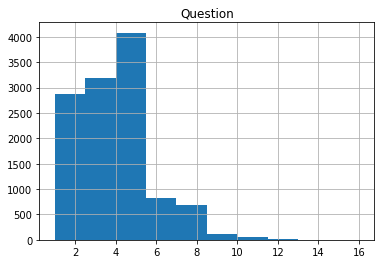

In [13]:
plt.title('Question')
chat_df['count_q'].hist()

<AxesSubplot:title={'center':'Answer'}>

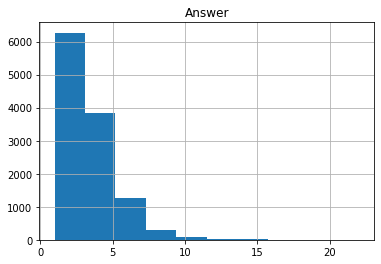

In [14]:
plt.title('Answer')
chat_df['count_a'].hist()

## 토크나이저 (Tokenizer)

In [15]:
import tensorflow_datasets as tfds
print("살짝 오래 걸릴 수 있어요. 스트레칭 한 번 해볼까요? 👐")

# 질문과 답변 데이터셋에 대해서 Vocabulary 생성. (Tensorflow 2.3.0 이상) (클라우드는 2.4 입니다)
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(question + answer, target_vocab_size=2**13)

살짝 오래 걸릴 수 있어요. 스트레칭 한 번 해볼까요? 👐


In [16]:
import tensorflow_datasets as tfds

In [17]:
# 시작 토큰과 종료 토큰에 고유한 정수를 부여합니다.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

In [18]:
print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])

START_TOKEN의 번호 : [8361]
END_TOKEN의 번호 : [8362]


In [19]:
# 시작 토큰과 종료 토큰을 고려하여 +2를 하여 단어장의 크기를 산정합니다.
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

8363


In [20]:
# 임의의 22번째 샘플에 대해서 정수 인코딩 작업을 수행.
# 각 토큰을 고유한 정수로 변환
print('정수 인코딩 후의 21번째 질문 샘플: {}'.format(tokenizer.encode(question[21])))
print('정수 인코딩 후의 21번째 답변 샘플: {}'.format(tokenizer.encode(answer[21])))

정수 인코딩 후의 21번째 질문 샘플: [5824, 602, 2498, 4170]
정수 인코딩 후의 21번째 답변 샘플: [2683, 7666, 6, 6375, 92, 8151]


In [21]:
# 샘플의 최대 허용 길이 또는 패딩 후의 최종 길이
MAX_LENGTH = 15
print(MAX_LENGTH)

15


In [22]:
def tokenize_and_filter(inputs, outputs):
    tokenized_inputs, tokenized_outputs = [], []
    
    for (sentence1, sentence2) in zip(inputs, outputs):
        sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
        sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN
        
        if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
            tokenized_inputs.append(sentence1)
            tokenized_outputs.append(sentence2)
    
    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
                        tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
    tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
                        tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
    
    return tokenized_inputs, tokenized_outputs

In [23]:
question, answer = tokenize_and_filter(question, answer)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(question)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answer)))

단어장의 크기 : 8363
필터링 후의 질문 샘플 개수: 11570
필터링 후의 답변 샘플 개수: 11570


In [24]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': question,
        'dec_inputs': answer[:, :-1]
    },
    {
        'outputs': answer[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

## 모델 정의 및 학습하기 (Modeling)

- 포지셔널 인코딩

In [25]:
class PositionalEncoding(tf.keras.layers.Layer):
    
    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)
        
    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles
    
    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(
            position = tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i = tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model)
        
        # 배열의 짝수 인덱스에는 sin 함수 적용
        sines = tf.math.sin(angle_rads[:, 0::2])
        # 배열의 홀수 인덱스에는 cosine 함수 적용
        cosines = tf.math.cos(angle_rads[:, 1::2])
        
        pos_encoding = tf.stack([sines, cosines], axis=0)
        pos_encoding = tf.transpose(pos_encoding, [1, 2, 0])
        pos_encoding = tf.reshape(pos_encoding, [position, d_model])
        
        pos_encoding = pos_encoding[tf.newaxis, ...]
        
        return tf.cast(pos_encoding, tf.float32)
    
    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

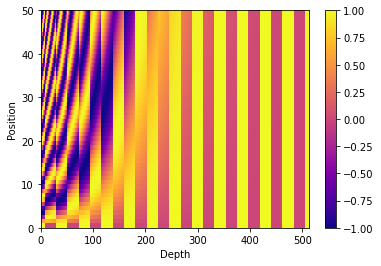

In [26]:
sample_pos_encoding = PositionalEncoding(50, 512)

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap='plasma')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

- 어텐션

Attention(Q, K, V) = Attention Value

Q = Query : t 시점의 디코더 셀에서의 은닉 상태


K = Keys : 모든 시점의 인코더 셀의 은닉 상태들


V = Values : 모든 시점의 인코더 셀의 은닉 상태들

어텐션 함수는 주어진 '쿼리(Query)'에 대해서 모든 '키(Key)'와의 유사도를 각각 구한다. 그리고 구해낸 이 유사도를 키(Key)와 맵핑되어있는 각각의 '값(Value)'에 반영해 준다. 그리고 유사도가 반영된 '값(Value)'을 모두 더해서 뭉쳐주면 이를 최종 결과인 어텐션 값(Attention Value) 라고 한다.

In [27]:
# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
    # 어텐션 가중치는 Q와 K의 닷 프로덕트
    matmul_qk = tf.matmul(query, key, transpose_b=True)
    
    #가중치를 정규화
    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)
    
    #패딩에 마스크 추가
    if mask is not None:
        logits += (mask * -1e9)
        
    #softmax 적용
    attention_weights = tf.nn.softmax(logits, axis=-1)
    
    # 최종 어텐션은 가중치와 V의 닷 프로덕트
    output = tf.matmul(attention_weights, value)
    return output

In [28]:
#멀티헤드어텐션

class MultiHeadAttention(tf.keras.layers.Layer):
    
    def __init__(self, d_model, num_heads, name='multi_head_attention'):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model
        
        assert d_model % self.num_heads == 0
        
        self.depth = d_model // self.num_heads
        
        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)
        
        self.dense = tf.keras.layers.Dense(units=d_model)
        
    def split_heads(self, inputs, batch_size):
        inputs = tf.reshape(
            inputs, shape=(batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(inputs, perm=[0, 2, 1, 3])
    
    def call(self, inputs):
        query, key, value, mask = inputs['query'], inputs['key'], inputs['value'], inputs['mask']
        batch_size = tf.shape(query)[0]
        
         # Q, K, V에 각각 Dense를 적용합니다
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)
        
         # 병렬 연산을 위한 머리를 여러 개 만듭니다
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)
        
        # 스케일드 닷 프로덕트 어텐션 함수
        scaled_attention = scaled_dot_product_attention(query, key, value, mask)
        
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        
        # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
        concat_attention = tf.reshape(scaled_attention,
                                      (batch_size, -1, self.d_model))
        
         # 최종 결과에도 Dense를 한 번 더 적용합니다
        outputs = self.dense(concat_attention)
        
        return outputs

멀티-헤드 어텐션(Multi-Head Attention)은 셀프 어텐션(self attention)을 여러 번 수행한 것이다.

- 패딩 마스킹(Padding Masking)

마스킹(Masking): 특정 값들을 가려서 실제 연산에 방해가 되지 않도록 하는 기법

패딩 마스킹(Padding Masking):  패딩은 문장의 길이가 서로 다를 때, 모든 문장의 길이를 동일하게 해주는 과정에서 정해준 길이보다 짧은 문장의 경우에는 숫자 0을 채워서 문장의 길이를 맞춰주는 자연어 처리 기법. 이렇게 주어진 숫자 0은 실제 의미가 있는 단어가 아니므로 실제 어텐션 등과 같은 연산에서는 제외할 필요가 있다. 패딩 마스킹은 이를 위해 숫자 0인 위치를 체크한다.

In [29]:
def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
    
    return mask[:, tf.newaxis, tf.newaxis, :]

- 룩 어헤드 마스킹(Look-ahead masking, 다음 단어 가리기)

In [30]:
# 자신 다음에 나올 단어를 참고하지 않도록 마스킹
def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(x)
    
    return tf.maximum(look_ahead_mask, padding_mask)

In [31]:
# 0 이 포함되어 있을 때 작동 확인
print(create_look_ahead_mask(tf.constant([[0, 2, 0, 3, 5]])))

tf.Tensor(
[[[[1. 1. 1. 1. 1.]
   [1. 0. 1. 1. 1.]
   [1. 0. 1. 1. 1.]
   [1. 0. 1. 0. 1.]
   [1. 0. 1. 0. 0.]]]], shape=(1, 1, 5, 5), dtype=float32)


- 인코더

In [32]:
# 인코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재합니다.
def encoder_layer(units, d_model, num_heads, dropout, name='encoder_layer'):
    inputs = tf.keras.Input(shape=(None, d_model), name='inputs')
    
    # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
    
    # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention = MultiHeadAttention(
                d_model, num_heads, name='attention')({
                'query': inputs,
                'key': inputs,
                'value': inputs,
                'mask': padding_mask
    })
    
    # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    attention = tf.keras.layers.LayerNormalization(
                epsilon=1e-6)(inputs + attention)
    
    # 두 번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)
    
    # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
                epsilon=1e-6)(attention + outputs)
    
    return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)

인코더 층을 쌓아 인코더 만들기

In [33]:
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='encoder'):
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    
    # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
    
    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
    
    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)
    
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)
    
    # num_layers만큼 쌓아올린 인코더의 층.
    for i in range(num_layers):
        outputs = encoder_layer(
                    units=units,
                    d_model=d_model,
                    num_heads=num_heads,
                    dropout=dropout,
                    name='encoder_layer_{}'.format(i))([outputs, padding_mask])
        
    return tf.keras.Model(
            inputs=[inputs, padding_mask], outputs=outputs, name=name)

- 디코더

In [34]:
# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.
def decoder_layer(units, d_model, num_heads, dropout, name='decoder_layer'):
    inputs = tf.keras.Input(shape=(None, d_model), name='inputs')
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name="look_ahead_mask")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
    
    # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention1 = MultiHeadAttention(
                    d_model, num_heads, name='attention_1')(inputs={
                        'query': inputs,
                        'key': inputs,
                        'value': inputs,
                        'mask': look_ahead_mask
                    })
    
    # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention1 + inputs)
    
    # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
    attention2 = MultiHeadAttention(
                    d_model, num_heads, name='attention_2')(inputs={
                        'query': attention1,
                        'key': enc_outputs,
                        'value': enc_outputs,
                        'mask': padding_mask
                    })
    
    # 마스크드 멀티 헤드 어텐션의 결과는
    # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
    attention2 = tf.keras.layers.LayerNormalization(
                epsilon=1e-6)(attention2 + attention1)
   
     # 세 번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)
    
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(outputs + attention2)
    
    return tf.keras.Model(
            inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
            outputs=outputs,
            name=name)

디코더 층을 쌓아 디코더 만들기

In [35]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name='look_ahead_mask')
    
    # 패딩 마스크
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
    
    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
    
    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)
    
    # Dropout이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)
    
    for i in range(num_layers):
        outputs = decoder_layer(
                    units=units,
                    d_model=d_model,
                    num_heads=num_heads,
                    dropout=dropout,
                    name='decoder_layer_{}'.format(i))(
        inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])
        
    return tf.keras.Model(
            inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
            outputs=outputs,
            name=name)

- 트랜스포머(transformer)

셀프 어텐션 : 유사도를 구하는 대상이 다른 문장의 단어가 아니라 현재 문장 내의 단어들이 서로 유사도를 구하는 경우(어텐션을 자기 자신에게 수행한다는 의미)



In [36]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    dec_inputs = tf.keras.Input(shape=(None,), name='dec_inputs')
    
    # 인코더에서 패딩을 위한 마스크
    enc_padding_mask = tf.keras.layers.Lambda(
                        create_padding_mask, 
                        output_shape=(1, 1, None),
                        name='enc_padding_mask')(inputs)
    
    # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
    # 내부적으로 패딩 마스크도 포함되어져 있습니다.
    look_ahead_mask = tf.keras.layers.Lambda(
                        create_look_ahead_mask,
                        output_shape=(1, None, None),
                        name='look_ahead_mask')(dec_inputs)
    
    # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
    # 디코더에서 패딩을 위한 마스크
    dec_padding_mask = tf.keras.layers.Lambda(
                        create_padding_mask, output_shape=(1, 1, None),
                        name='dec_padding_mask')(inputs)
    
    # 인코더
    enc_outputs = encoder(
                  vocab_size=vocab_size,
                  num_layers=num_layers,
                  units=units,
                  d_model=d_model,
                  num_heads=num_heads,
                  dropout=dropout
                )(inputs=[inputs, enc_padding_mask])
    
    # 디코더
    dec_outputs = decoder(
                  vocab_size=vocab_size,
                  num_layers=num_layers,
                  units=units,
                  d_model=d_model,
                  num_heads=num_heads,
                  dropout=dropout
                )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])
    
    # 완전연결층
    outputs = tf.keras.layers.Dense(units=vocab_size, name='outputs')(dec_outputs)
    
    return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

In [37]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 256)    3195136     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

- 손실함수(loss function)

In [38]:
def loss_function(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    
    loss = tf.keras.losses.SparseCategoricalCrossentropy(
            from_logits=True, reduction='none')(y_true, y_pred)
    
    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = tf.multiply(loss, mask)

    return tf.reduce_mean(loss)

- 커스텀 된 학습률(Learning rate)

In [39]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

- 모델 컴파일

손실 함수와 커스텀 된 학습률(learning rate)을 사용하여 모델을 컴파일

In [40]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
            learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [41]:
EPOCHS = 30
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/30
181/181 [==============================] - 12s 33ms/step - loss: 3.9561 - accuracy: 0.0813
Epoch 2/30
181/181 [==============================] - 6s 33ms/step - loss: 3.2290 - accuracy: 0.1379
Epoch 3/30
181/181 [==============================] - 6s 33ms/step - loss: 2.7323 - accuracy: 0.1408
Epoch 4/30
181/181 [==============================] - 6s 33ms/step - loss: 2.5176 - accuracy: 0.1508
Epoch 5/30
181/181 [==============================] - 6s 33ms/step - loss: 2.3573 - accuracy: 0.1596
Epoch 6/30
181/181 [==============================] - 6s 33ms/step - loss: 2.1967 - accuracy: 0.1705
Epoch 7/30
181/181 [==============================] - 6s 33ms/step - loss: 2.0233 - accuracy: 0.1857
Epoch 8/30
181/181 [==============================] - 6s 33ms/step - loss: 1.8299 - accuracy: 0.2065
Epoch 9/30
181/181 [==============================] - 6s 33ms/step - loss: 1.6217 - accuracy: 0.2298
Epoch 10/30
181/181 [==============================] - 6s 33ms/step - loss: 1.3996 - accur

## 챗봇 테스트하기 (Evaluate)


In [42]:
def decoder_inference(sentence):
    sentence = preprocess_sentence(sentence)
    
    # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
    # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
    sentence = tf.expand_dims(
                START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)
    
    # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
    # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
    output_sequence = tf.expand_dims(START_TOKEN, 0)
    
    # 디코더의 인퍼런스 단계   
    for i in range(MAX_LENGTH):
        predictions = model(inputs=[sentence, output_sequence], training=False)
        predictions = predictions[:, -1:, :]
        
        # 현재 예측한 단어의 정수
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
        
        # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
        if tf.equal(predicted_id, END_TOKEN[0]):
            break
            
        # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
        # 이 output_sequence는 다시 디코더의 입력이 됩니다.
        output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)
        
    return tf.squeeze(output_sequence, axis=0)

In [43]:
def sentence_generation(sentence):
   # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.    
    prediction = decoder_inference(sentence)
    
    # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
    predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

    print('입력 : {}'.format(sentence))
    print('출력 : {}'.format(predicted_sentence))

    return predicted_sentence

In [44]:
sentence_generation("심심해")

입력 : 심심해
출력 : 저랑 놀아요.


'저랑 놀아요.'

In [45]:
sentence_generation("배고프다")

입력 : 배고프다
출력 : 저도 밥 먹고 싶어요


'저도 밥 먹고 싶어요'

In [46]:
sentence_generation('오늘 점심 뭐 먹지?')

입력 : 오늘 점심 뭐 먹지?
출력 : 맛있는 거 드세요.


'맛있는 거 드세요.'

In [47]:
sentence_generation('너무 졸려')

입력 : 너무 졸려
출력 : 낮잠을 잠깐 자도 괜찮아요.


'낮잠을 잠깐 자도 괜찮아요.'

## Retrospection

문장을 넣었을 때 제대로 된 답변을 받을 수 있었다. 하지만 '뭐해?'나 '기분이 어때?' 같은 경우에는 답변이 문맥에 맞지 않게 나왔다. 이 부분에 있어서는 다른 시도를 해봐야 할 것 같다.

전반적으로 어려웠던 노드였다.